## Week 6 assignment

##### Setup

Use the dataset containing short sentences translated from English to Finnish (fin-eng.zip), that can be downloaded at https://www.manythings.org/anki/.

##### Task

Build and train a Transformer model to translate sentences from English to Finnish with the dataset referred to above. You can use the same classes for embedding (token + positional) layer and Transformer encoder and decoder as in Chollet's "Deep Learning with Python" and weekly material. As for the actual model, follow the similar example with English-Spanish translation in Chollet's book; also, you can use the code below to read the sentences from the file:

```python
text_file = "fin-eng/fin.txt"

with open(text_file, encoding='utf-8') as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    english, finnish, rest = line.split("\t")
    finnish = "[start] " + finnish + " [end]"
    text_pairs.append((english, finnish))
```

Provide the notebook also with a couple of examples showing translated sentences. If the results are less than impressive, never mind; a genuine effort is all that is expected of this exercise.


#### Data preparation

Fetching data from text file and constructing english, finnish word pairs from it.

In [17]:
# Discard unnessecary logs from gpu
import os; os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
from keras.saving import register_keras_serializable

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))
print("GPU devices:", tf.config.list_physical_devices('GPU'))

print(tf.__version__)
print(tf.__path__)



Num GPUs Available: 1
GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
2.19.0
['/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/keras/api/_v2', '/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/keras/_tf_keras', '/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/tensorflow', '/home/tensor/miniconda3/envs/tensor-g/lib/python3.12/site-packages/tensorflow/_api/v2']


In [18]:
import random

# Extract text from file to

text_file = "../data/fin.txt"


with open(text_file, encoding="utf-8") as f:

    lines = f.read().split("\n")[:-1]

text_pairs = []

for line in lines:
    english, finnish, rest = line.split("\t")
    finnish = "[start] " + finnish + " [end]"
    text_pairs.append((english, finnish))

random.choice(text_pairs)

('Hit the brakes.', '[start] Jarruttakaa. [end]')

#### Splitting dataset to train, validation and test sets

In [19]:
random.shuffle(text_pairs)

num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples:num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

#### Vectorization of word pairs

In [20]:
import tensorflow as tf
import string
import re
from keras import layers


strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")


def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")


vocab_size = 15000
sequence_length = 20

source_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

train_english_texts = [pair[0] for pair in train_pairs]
train_finnish_texts = [pair[1] for pair in train_pairs]

val_english_texts = [pair[0] for pair in val_pairs]
val_finnish_texts = [pair[1] for pair in val_pairs]

test_english_texts = [pair[0] for pair in test_pairs]
test_finnish_texts = [pair[1] for pair in test_pairs]

source_vectorization.adapt(train_english_texts)
target_vectorization.adapt(train_finnish_texts)

source_vectorization.adapt(val_english_texts)
target_vectorization.adapt(val_finnish_texts)

source_vectorization.adapt(test_english_texts)
target_vectorization.adapt(test_finnish_texts)

#### Dataset preparation for translation task

In [21]:
batch_size = 32


def format_dataset(eng, fin):
    eng = source_vectorization(eng)
    fin = target_vectorization(fin)
    return (
        {
            "english": eng,
            "finnish": fin[:, :-1],
        },
        fin[:, 1:],
    )


def make_dataset(pairs):
    eng_texts, spa_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)
    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()


train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
test_ds = make_dataset(test_pairs)

##### Print shape of datasets

In [22]:
for inputs, targets in train_ds.take(1):
    print(f"inputs['english'].shape: {inputs['english'].shape}")
    print(f"inputs['finnish'].shape: {inputs['finnish'].shape}")
    print(f"targets.shape: {targets.shape}")

inputs['english'].shape: (32, 20)
inputs['finnish'].shape: (32, 20)
targets.shape: (32, 20)


2025-05-05 09:44:51.200554: W tensorflow/core/kernels/data/cache_dataset_ops.cc:916] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-05-05 09:44:51.201818: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### Model


##### Positional Embedding

In [23]:
from keras import layers
from keras import ops


@register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

##### Transformer Encoder

In [24]:
import keras

@register_keras_serializable()
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

##### Transformer Decoder

In [25]:
@register_keras_serializable()
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "num_heads": self.num_heads,
                "dense_dim": self.dense_dim,
            }
        )
        return config

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1), tf.constant([1, 1], dtype=tf.int32)],
            axis=0,
        )
        return tf.tile(mask, mult)

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None
        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention_2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)

#### Transformer Model

In [26]:
embed_dim = 256
dense_dim = 2048
num_heads = 8

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="finnish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

transformer.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ finnish             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ english[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,845,120 │ finnish[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 256) │  3,155,456 │ positional_embed… │
│ (TransformerEncode… │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, None, 256) │  5,259,520 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, None, 256) │          0 │ transformer_deco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, None,      │  3,855,000 │ dropout_9[0][0]   │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,960,216 (76.14 MB)

 Trainable params: 19,960,216 (76.14 MB)

 Non-trainable params: 0 (0.00 B)

#### Training the model

In [27]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam


checkpoint_filepath = "./models/ckpt/checkpoint.model.keras"

model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor="val_accuracy",
    mode="max",
    save_best_only=True,
)

early_stopping = EarlyStopping(monitor="val_loss", patience=4)

transformer.compile(
    optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)

history = transformer.fit(
    train_ds, epochs=30, validation_data=val_ds, callbacks=[model_checkpoint_callback]
)

transformer.save("transformer_fi_en.keras")

Epoch 1/30


I0000 00:00:1746427501.847040     860 service.cc:152] XLA service 0x7f531c002ad0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746427501.847083     860 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce GTX 1080, Compute Capability 6.1
2025-05-05 09:45:02.026016: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-05 09:45:02.447151: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
I0000 00:00:1746427502.959855     860 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-05 09:45:07.237013: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_add_reduce_fusion_12', 36 bytes spill 

 966/1581 ━━━━━━━━━━━━━━━━━━━━ 20s 33ms/step - accuracy: 0.1895 - loss: 4.7373

2025-05-05 09:45:40.000753: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1785 - loss: 4.4732

2025-05-05 09:46:06.644391: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2025-05-05 09:46:08.016199: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


1581/1581 ━━━━━━━━━━━━━━━━━━━━ 76s 41ms/step - accuracy: 0.1785 - loss: 4.4729 - val_accuracy: 0.1676 - val_loss: 3.1915
Epoch 2/30
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.1690 - loss: 3.1643 - val_accuracy: 0.1801 - val_loss: 2.7859
Epoch 3/30
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.1826 - loss: 2.7194 - val_accuracy: 0.1903 - val_loss: 2.4876
Epoch 4/30
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.1929 - loss: 2.3949 - val_accuracy: 0.1969 - val_loss: 2.3100
Epoch 5/30
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.2007 - loss: 2.1588 - val_accuracy: 0.1992 - val_loss: 2.2135
Epoch 6/30
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.2071 - loss: 1.9749 - val_accuracy: 0.2033 - val_loss: 2.1122
Epoch 7/30
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.2126 - loss: 1.8216 - val_accuracy: 0.2063 - val_loss: 2.0656
Epoch 8/30
1581/1581 ━━━━━━━━━━━━━━━━━━━━ 57s 36ms/step - accuracy: 0.2172 - loss: 1.69

In [29]:
# Optionally load existing model
from keras.saving import load_model

transformer = load_model(
    "transformer_fi_en.keras",
    custom_objects={
        "PositionalEmbedding": PositionalEmbedding,
        "TransformerEncoder": TransformerEncoder,
        "TransformerDecoder": TransformerDecoder,
    },
)

#### Evaluation

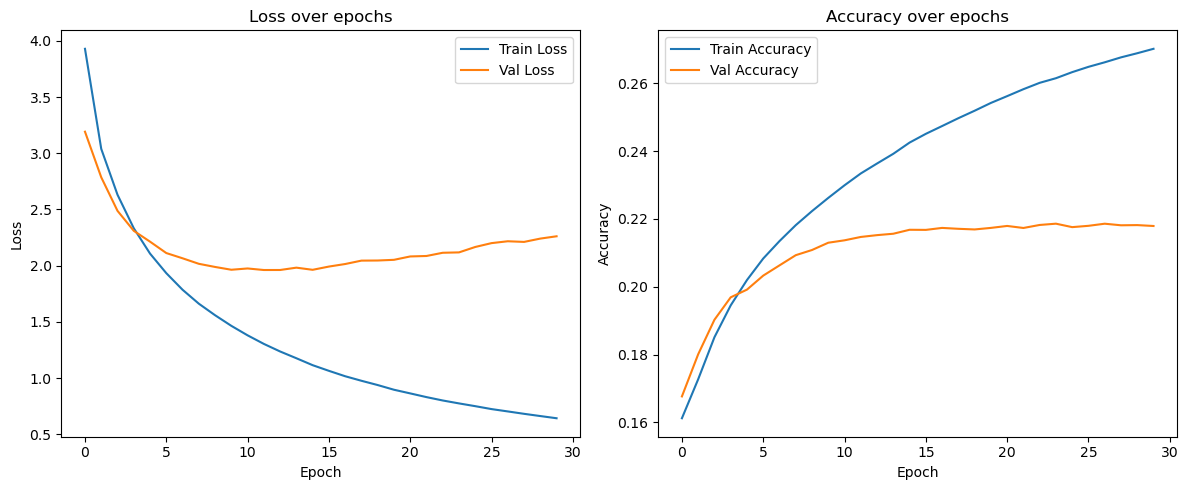

2025-05-05 10:31:25.455199: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


211/339 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.2020 - loss: 3.7052

2025-05-05 10:31:28.372613: W tensorflow/compiler/tf2xla/kernels/assert_op.cc:39] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


339/339 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.2017 - loss: 3.7004
Test loss: 3.695080041885376
Test accuracy: 0.2015593945980072


In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss over epochs")
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy over epochs")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluate on test set
test_ds = make_dataset(test_pairs)

test_loss, test_acc = transformer.evaluate(test_ds)
print("Test loss:", test_loss)
print("Test accuracy:", test_acc)

#### Decode sentences without penalty

In [35]:
import numpy as np

fin_vocab = target_vectorization.get_vocabulary()
fin_index_lookup = dict(zip(range(len(fin_vocab)), fin_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"

    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        current_token_position = len(decoded_sentence.split()) - 1
        if current_token_position >= predictions.shape[1]:
            break

        next_token_probs = predictions[0, current_token_position, :]

        top_indices = np.argsort(next_token_probs)[-5:][::-1]
        sampled_token_index = top_indices[0]

        for idx in top_indices:
            token = fin_vocab[idx]
            if token != "[UNK]":
                sampled_token_index = idx
                break

        sampled_token = fin_vocab[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break

    tokens = decoded_sentence.split()
    tokens = [t for t in tokens if t not in ("[start]", "[end]")]
    return " ".join(tokens)


input_sentence = "Its snowing outside"
print("-")
print(input_sentence)
print(decode_sequence(input_sentence))

-
Its snowing outside
ulkona sataa lunta


#### Decode sentences with penalty

Test to decode sentences with added penalty.

In [36]:
def decode_sequence_with_penalty(input_sentence, repetition_penalty=1.2):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    generated_tokens = []
    
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])
        
        current_token_position = len(decoded_sentence.split()) - 1
        if current_token_position >= predictions.shape[1]:
            break
            
        # Get logits and apply repetition penalty
        next_token_logits = predictions[0, current_token_position, :].numpy()
        
        # Penalize already generated tokens
        for token_id in generated_tokens:
            next_token_logits[token_id] /= repetition_penalty
        
        # Get top tokens after penalty
        next_token_probs = np.exp(next_token_logits) / np.sum(np.exp(next_token_logits))
        top_indices = np.argsort(next_token_probs)[-5:][::-1]
        sampled_token_index = top_indices[0]
        
        # Avoid UNK tokens
        for idx in top_indices:
            token = fin_vocab[idx]
            if token != "[UNK]":
                sampled_token_index = idx
                break
                
        sampled_token = fin_vocab[sampled_token_index]
        generated_tokens.append(sampled_token_index)
        decoded_sentence += " " + sampled_token
        
        if sampled_token == "[end]":
            break
            
    tokens = decoded_sentence.split()
    tokens = [t for t in tokens if t not in ("[start]", "[end]")]
    return " ".join(tokens)

# Test with the repetition penalty decoder
print("\nWith repetition penalty:")
print(input_sentence)
print(decode_sequence_with_penalty(input_sentence))

# Try a few more examples
test_sentences = [
    "I love to read books",
    "The cat is sleeping on the sofa", 
    "Can you help me find my keys?"
]

print("\nMore examples with repetition penalty:")
for sentence in test_sentences:
    translation = decode_sequence_with_penalty(sentence)
    print(f"{sentence} → {translation}")


With repetition penalty:
Its snowing outside
ulkona sataa lunta

More examples with repetition penalty:
I love to read books → rakastan kirjojen lukemista
The cat is sleeping on the sofa → kissa nukkuu sohvalla
Can you help me find my keys? → voitko auttaa minua silmällä
